In [1]:
"""
SUMMARY:
Dbpedia 14 class/topic classification

Accuracy: X
Time per Epoch: X seconds = X rev/s
Total time: X*10 = X min = X hours
Train size = 560,000 
Test size = 70,000

DETAILS:
Attempt to replicate crepe model using MXNET:
https://github.com/zhangxiangxiao/Crepe

This uses an efficient numpy array (dtype=bool)
to hold all data in RAM. 

Run on 3 GPUs (Tesla K80) with batch=128*16*3
Peak RAM: X
"""

'\nSUMMARY:\nDbpedia 14 class/topic classification\n\nAccuracy: X\nTime per Epoch: X seconds = X rev/s\nTotal time: X*10 = X min = X hours\nTrain size = 2,097,152\nTest size = 233,016\n\nDETAILS:\nAttempt to replicate crepe model using MXNET:\nhttps://github.com/zhangxiangxiao/Crepe\n\nThis uses an efficient numpy array (dtype=bool)\nto hold all data in RAM. \n\nRun on 3 GPUs (Tesla K80) with batch=128*16*3\nPeak RAM: X\n'

In [2]:
%matplotlib inline
import numpy as np
import pickle
import pandas as pd
import mxnet as mx
import wget
import time
import os.path
import math
import matplotlib.pyplot as plt
import logging

In [26]:
AZ_ACC = "amazonsentimenik"
AZ_CONTAINER = "textclassificationdatasets"

ALPHABET = list("abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+ =<>()[]{}")
FEATURE_LEN = 1014
BATCH_SIZE = 128*16*3
NUM_FILTERS = 256
DATA_SHAPE = (BATCH_SIZE, 1, FEATURE_LEN, len(ALPHABET))

ctx = [mx.gpu(0), mx.gpu(1), mx.gpu(2)]
EPOCHS = 10
SD = 0.05  # std for gaussian distribution
NOUTPUT = 14  # Classes
INITY = mx.init.Normal(sigma=SD)
LR = 0.01
MOMENTUM = 0.9
WDECAY = 0.00001

In [4]:
# logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='crepe_dbp.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

In [5]:
def download_file(url):
    # Create file-name
    local_filename = url.split('/')[-1]
    if os.path.isfile(local_filename):
        pass
        # print("The file %s already exist in the current directory\n" % local_filename)
    else:
        # Download
        print("downloading ...\n")
        wget.download(url)
        print('\nsaved data')

In [6]:
def load_data_frame(infile, shuffle = False):
    print("processing data frame: %s" % infile)
    # Get data from windows blob
    download_file('https://%s.blob.core.windows.net/%s/%s' % (AZ_ACC, AZ_CONTAINER, infile))
        # load data into dataframe
    df = pd.read_csv(infile,
                     header=None,
                     names=['sentiment', 'summary', 'text'])
    # concat summary, review; trim to 1014 char; reverse; lower
    df['rev'] = df.apply(lambda x: "%s %s" % (x['summary'], x['text']), axis=1)
    df.rev = df.rev.str[:FEATURE_LEN].str[::-1].str.lower()
    # store class as nparray
    df.sentiment -= 1
    y_split = np.asarray(df.sentiment, dtype='bool')
    # drop columns
    df.drop(['text', 'summary', 'sentiment'], axis=1, inplace=True)
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)
    # Dictionary to create character vectors
    character_hash = pd.DataFrame(np.identity(len(ALPHABET), dtype='bool'), columns=ALPHABET)
    print("finished processing data frame: %s" % infile)
    print("data contains %d obs" % df.shape[0])
    batch_size = df.shape[0]
    # Create encoding
    X_split = np.zeros([batch_size, 1, FEATURE_LEN, len(ALPHABET)], dtype='bool')
    # Main loop
    for ti, tx in enumerate(df.rev):
        if (ti+1) % (100*1000) == 0:
            print("Processed: ", ti+1)
        chars = list(tx)
        for ci, ch in enumerate(chars):
            if ch in ALPHABET:
                X_split[ti % batch_size][0][ci] = np.array(character_hash[ch], dtype='bool')
                
    # Return as a DataBatch
    #return DataBatch(data=[mx.nd.array(X_split)],
    #                 label=[mx.nd.array(y_split[ti + 1 - batch_size:ti + 1])])
    return X_split, y_split

In [7]:
def create_crepe():
    """
    Replicating: https://github.com/zhangxiangxiao/Crepe/blob/master/train/config.lua
    """
    input_x = mx.sym.Variable('data')  # placeholder for input
    input_y = mx.sym.Variable('softmax_label')  # placeholder for output
    # 1. alphabet x 1014
    conv1 = mx.symbol.Convolution(
        data=input_x, kernel=(7, 69), num_filter=NUM_FILTERS)
    relu1 = mx.symbol.Activation(
        data=conv1, act_type="relu")
    pool1 = mx.symbol.Pooling(
        data=relu1, pool_type="max", kernel=(3, 1), stride=(3, 1))
    # 2. 336 x 256
    conv2 = mx.symbol.Convolution(
        data=pool1, kernel=(7, 1), num_filter=NUM_FILTERS)
    relu2 = mx.symbol.Activation(
        data=conv2, act_type="relu")
    pool2 = mx.symbol.Pooling(
        data=relu2, pool_type="max", kernel=(3, 1), stride=(3, 1))
    # 3. 110 x 256
    conv3 = mx.symbol.Convolution(
        data=pool2, kernel=(3, 1), num_filter=NUM_FILTERS)
    relu3 = mx.symbol.Activation(
        data=conv3, act_type="relu")
    # 4. 108 x 256
    conv4 = mx.symbol.Convolution(
        data=relu3, kernel=(3, 1), num_filter=NUM_FILTERS)
    relu4 = mx.symbol.Activation(
        data=conv4, act_type="relu")
    # 5. 106 x 256
    conv5 = mx.symbol.Convolution(
        data=relu4, kernel=(3, 1), num_filter=NUM_FILTERS)
    relu5 = mx.symbol.Activation(
        data=conv5, act_type="relu")
    # 6. 104 x 256
    conv6 = mx.symbol.Convolution(
        data=relu5, kernel=(3, 1), num_filter=NUM_FILTERS)
    relu6 = mx.symbol.Activation(
        data=conv6, act_type="relu")
    pool6 = mx.symbol.Pooling(
        data=relu6, pool_type="max", kernel=(3, 1), stride=(3, 1))
    # 34 x 256
    flatten = mx.symbol.Flatten(data=pool6)
    # 7.  8704
    fc1 = mx.symbol.FullyConnected(
        data=flatten, num_hidden=1024)
    act_fc1 = mx.symbol.Activation(
        data=fc1, act_type="relu")
    drop1 = mx.sym.Dropout(act_fc1, p=0.5)
    # 8. 1024
    fc2 = mx.symbol.FullyConnected(
        data=drop1, num_hidden=1024)
    act_fc2 = mx.symbol.Activation(
        data=fc2, act_type="relu")
    drop2 = mx.sym.Dropout(act_fc2, p=0.5)
    # 9. 1024
    fc3 = mx.symbol.FullyConnected(
        data=drop2, num_hidden=NOUTPUT)
    crepe = mx.symbol.SoftmaxOutput(
        data=fc3, label=input_y, name="softmax")
    return crepe

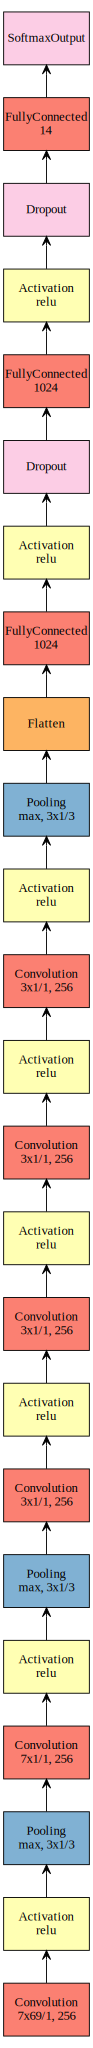

In [8]:
# Visualise symbol (for crepe)
crepe = create_crepe()

a = mx.viz.plot_network(crepe)
a.render('Crepe Model')
a

In [9]:
train_x, train_y = load_data_frame('dbpedia_train.csv')

processing data frame: dbpedia_train.csv
finished processing data frame: dbpedia_train.csv
data contains 560000 obs
('Processed: ', 100000)
('Processed: ', 200000)
('Processed: ', 300000)
('Processed: ', 400000)
('Processed: ', 500000)


In [10]:
test_x, test_y = load_data_frame('dbpedia_test.csv')

processing data frame: dbpedia_test.csv
finished processing data frame: dbpedia_test.csv
data contains 70000 obs


In [11]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(560000L, 1L, 1014L, 69L)
(560000L,)
(70000L, 1L, 1014L, 69L)
(70000L,)


In [12]:
train_iter = mx.io.NDArrayIter(train_x, train_y, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
test_iter = mx.io.NDArrayIter(test_x, test_y, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
del train_x
del train_y
del test_x

In [27]:
model = mx.model.FeedForward(
    ctx = ctx,
    symbol = create_crepe(), 
    num_epoch = EPOCHS,  # number of training rounds
    learning_rate = LR,  # learning rate
    momentum = MOMENTUM,   # momentum for sgd
    wd = WDECAY,  # weight decay for reg
    initializer = INITY  # init with sd of 0.05
)

In [28]:
tic = time.time()
model.fit(
    X = train_iter,
    eval_metric=['accuracy'],
    batch_end_callback=mx.callback.Speedometer(100*BATCH_SIZE),
    epoch_end_callback=mx.callback.do_checkpoint("crepe_dbp_chck_") 
)
print("Finished training in %.0f seconds" % (time.time() - tic))

MXNetError: [22:35:44] d:\chhong\mxnet\src\storage\./gpu_device_storage.h:39: Check failed: e == cudaSuccess || e == cudaErrorCudartUnloading CUDA: out of memory

In [25]:
# Predict
pred = np.argsort(model.predict(X = test_iter))[:,-1]

# Save Results
np.savetxt('crepe_predict_class_dbpedia.csv', np.c_[pred, test_y], delimiter=',', fmt='%d')

MXNetError: [22:35:20] d:\chhong\mxnet\src\storage\./gpu_device_storage.h:39: Check failed: e == cudaSuccess || e == cudaErrorCudartUnloading CUDA: out of memory

In [ ]:
# Accuracy
acc = sum(pred==test_y.astype('int'))/float(len(test_y))
logger.info(acc)
acc 